# Import Source data from Kaggle

Import and clean IPO Data
Data set has 3,762 rows, each row representing the IPO company
Over 1,600 columns
The file contains the open, close, low, high, and volume for the 261 trading days following the IPO. (1,305 data points). This data is listed inefficiently in the columns.

First step of data cleaning will be to use the source data to create two tables
    1. A pricing table simply listing the stock ticker and trading day as attribute columns. Stock open, close, low, high, and volume will be listed as the values
    2. An attribute table containing metadata on the stock ticker. I.e. company name, date founded, IPO date, CEO, headquartered location, etc. (all of these data points are on the source file as well


In [114]:
#import packages
import pandas as pd
import numpy as np

#import raw data as RawDF
RawDF = pd.read_csv('IPO Data.csv',low_memory = False, encoding='ISO-8859-1')

#break off stockticker and pricing data
Pricing = RawDF.iloc[:,0:1319]
Pricing = Pricing.drop(Pricing.columns[1:9], axis = 1)

#Reindex to symbol 
Pricing = Pricing.set_index('Symbol')

#add Ipo date to dateframe
IPO_Date = RawDF.loc[:,['Symbol','ipoDate']].set_index('Symbol')
IPO_Date['ipoDate'] = pd.to_datetime(IPO_Date['ipoDate'])
Pricing = pd.concat([Pricing,IPO_Date], axis = 1)

#after inspection I foudn that MITT repeated 64 times. Drop the duplicates here
Pricing = Pricing.drop_duplicates()
RawDF.shape

(3762, 1664)

### Pull out daily pricing from the columns to make a Pricing Table
The next sub routine will loop through the pricing dataframe established above and create a new dataframe with the Symbol, Trading Day, Open, Closing, Low, High, and Volume as the column. Row will represent the values for a stock on the given trading day

In [115]:
import datetime as dt

#need to clean data and create a new talbe with ticker, trading day, open price, close price, high, low, and volume
#in columns with the values for in the rows

#create empty lists for my columns
tday = []
Closing = []
High = []
Opening = []
Low = []
Volume = []
tday = []

cols = 0
day = 0

#loop through each column of the dataframe to store the pertenint data
while cols <= 1305:
    
    df = pd.DataFrame(Pricing.index)
    df['trade day'] = day
    tday.append(df)
    Closing.append(Pricing.iloc[:,cols]) #closing price starts at 0
    High.append(Pricing.iloc[:,cols+1]) #high one column over from closing
    Opening.append(Pricing.iloc[:,cols+2]) #opening two columns over from closing
    Low.append(Pricing.iloc[:,cols+3]) # low 3 columns over from closing
    Volume.append(Pricing.iloc[:,cols+4]) #Volume 3 columns over
    
    day = day + 1
    cols = cols + 5 #increment column by 5 (new day is every 5 columns)

#run concatenations on the indexes, to turn into dataframes     
df_Closing = pd.concat(Closing, axis = 0).reset_index()
df_Closing = df_Closing.drop(df_Closing.columns[0], axis = 1)

df_High = pd.concat(High, axis = 0).reset_index()
df_High = df_High.drop(df_High.columns[0], axis = 1)

df_Opening = pd.concat(Opening, axis = 0).reset_index()
df_Opening = df_Opening.drop(df_Opening.columns[0], axis = 1)

df_Low = pd.concat(Low, axis = 0).reset_index()
df_Low = df_Low.drop(df_Low.columns[0], axis = 1)

df_Volume = pd.concat(Volume, axis = 0).reset_index()
df_Volume = df_Volume.drop(df_Volume.columns[0], axis = 1)

df_Day = pd.concat(tday, axis = 0).reset_index()
df_Day = df_Day.drop(df_Day.columns[0], axis = 1)

#concatenate all the above dataframes vertically
df_pricing = pd.concat([df_Day, df_Closing, df_High, df_Opening, df_Low, df_Volume], axis = 1)
df_pricing.columns = ['Symbol', 'Trade Day', 'C', 'H', 'O', 'L', 'V']

#inspect new dataframe
#should have 261 records for each ticker (1 for each trading day)
#drop na's or records that don't have any pricing data
df_pricing.dropna(inplace = True)
df_pricing

,Symbol,Trade Day,C,H,O,L,V
0,A,0,28.6358,33.5207,27.3725,30.6572,59753154.0
1,AAC,0,18.5000,20.1000,17.6000,20.0000,2799073.0
2,AAOI,0,9.9600,10.0900,9.3700,10.0000,948999.0
3,AAP,0,13.9000,14.4667,13.3833,13.4000,371100.0
4,AAT,0,21.2500,22.0000,21.1800,21.5300,15536889.0
...,...,...,...,...,...,...,...
968603,ZNH,261,3.9587,4.0000,3.8753,3.8753,98700.0
968606,ZSAN,261,45.6000,45.6000,42.8000,42.8000,21.0
968607,ZTO,261,15.7300,15.8950,15.3500,15.6000,1922801.0
968611,ZX,261,3.4600,3.5500,3.3600,3.5300,22850.0


# Write Function to Compare Price Changes for Two given sets of Days

When I get further into analysis I'm going to want to compare the price changes between two given sets of days. The below function will take in 4 days and my pricing table created above. The output will create a dataframe giving me the percentage price change beteen Day1 and Day2 vs. percent change between Day3 and Day4

I.e. the below example I'm inputting 0 to 30 vs. 31 to 90

In [116]:
#Compare price changes based on 2 ranges


def PriceComp(Day1, Day2, Day3, Day4):

    Closing1 = df_pricing.loc[df_pricing['Trade Day']==Day1,['Symbol','C']].set_index('Symbol')
    Closing2 = df_pricing.loc[df_pricing['Trade Day']==Day2,['Symbol','C']].set_index('Symbol')
    Closing3 = df_pricing.loc[df_pricing['Trade Day']==Day3,['Symbol','C']].set_index('Symbol')
    Closing4 = df_pricing.loc[df_pricing['Trade Day']==Day4,['Symbol','C']].set_index('Symbol')

    Change1 = pd.merge(Closing1,Closing2, on = 'Symbol', how ='inner')
    Change1 = Change1.pct_change(axis = 'columns').drop('C_x', axis = 1)
    Change2 = pd.merge(Closing3, Closing4, on = 'Symbol', how = 'inner')
    Change2 = Change2.pct_change(axis = 'columns').drop('C_x', axis = 1)

    Change_Comp = pd.merge(Change1, Change2, on='Symbol', how = 'inner')
    Change_Comp.columns = [str(Day1) + ' to '+ str(Day2), str(Day3) + ' to '+ str(Day4)]
    Change_Comp = Change_Comp.apply(lambda x: x * 100)
    
    
    return Change_Comp

df = PriceComp(0,30,0,260)
print(df['0 to 260'].min())
print(df['0 to 260'].max())
print(df['0 to 260'].mean())
print(df['0 to 260'].std())

-99.99779999989
7519.047619047619
22.563932427874306
193.91681160663242


# Make Attribute Table with Key MetaData Points

My next step will be to create an attribute or metadata table containing all of the key stats on the stock company. There will be a record/row for each stock with multiple data points including date founded, revenue, income, ipoDate, day of week IPO'd, State, etc

In [117]:
#make my attribute table with the other metadata
#metadata is in columns 0 through 9 and all columns from 1319 to the end of the dataset. 
#the columns in the middle were pricing data points that I split off into the pricing table listed above

#split out desired columns using iloc. Concatenate back to one and inspect:
Attribute1 = RawDF.iloc[:,0:9]
Attribute2 = RawDF.iloc[:,1319:]
FullAttribute = pd.concat([Attribute1,Attribute2], axis = 1)
FullAttribute.shape

(3762, 354)

# Reduce Size of Metadata table by dropping irrelvant columns

After analysis my Attribute table still had 354 columns which was quite cumbersome. I reviewed the columns and found that the majority had N/A. To start the below code will identify columsn and % of N/A values. To start I'm only going to keep attributes with less than 50% N/A values. This leaves 50 columns wiht most of the key metadata I'm looking for. I.e. IPO date, CEO age/gender, company location, company age at IPO, year founded etc.

In [118]:
#create df with N/A percentages
nas=pd.DataFrame(FullAttribute.isnull().sum().sort_values(ascending=True)/len(FullAttribute),columns = ['percent'])

#filter percent less than 50
nasFilt = nas['percent']<=.5

#create and apply boolean series filter
tokeep = nas[nasFilt]
df_Att =FullAttribute.loc[:,tokeep.index]

#inspect data
df_Att.to_clipboard()
df_Att.shape


(3762, 50)

After significantly paring down my attribute table I reviewed all of the fields that were greater than 50% N/A to see if there's anything I wanted to keep. Most are key financila metrics for the company pre-IPO. My hypothesis is that these metrics would have an impact on pricing performance so I will need to find another datasource to pull those metrics in. For purposes of this exercise I'm not going to pull in all 304 rows but we'll start with the big ones:

Pre IPO Revenue ||
Pre IPO EBIDTA ||
Pre IPO Cash ||

I don't have a datasource for those yet so let's clean up the table we have and add a few functions in the next two steps

In [119]:
NullColumns =pd.DataFrame(FullAttribute.isnull().sum().sort_values(ascending=False)/len(FullAttribute),columns = ['percent'])
NullFilt = NullColumns['percent']>.50

NullColumns[NullFilt]

,percent
Other_intangiblesYearBeforeIPO,0.999734
Loans_issuedYearBeforeIPO,0.999734
Preferred_dividendsYearBeforeIPO,0.999734
Restricted_cash_and_cash_equivalentsYearBeforeIPO,0.999734
Provision_for_loan_lossesYearBeforeIPO,0.999734
...,...
Net_cash_provided_by_operating_activitiesYearBeforeIPO,0.891015
Net_incomeYearBeforeIPO,0.876396
Fiscal_year_ends_in_December_USDYearBeforeIPO,0.865231
exactDiffernce,0.583200


### Run Additional Conversion Functions to Clean Metadata

In [120]:
#create an attribute table for additional analysis
#pd.options.display.float_format = '{:.5f}'.format
#define US or Other country
def country(x):
    
    if len(str(x).strip()) == 2:
        return 'US'
    else:
        return 'Other'
        
#Revenue and Income columns end with 'B' to denote billions, 'M' to denote millions, or have the straight number if
# less than 1 million. The below function will stip the last character and convert to a float value that consistently
# represents revenue and income has millions. I.e. 1 billion displayed as 1,000; 1 million displayed as 1; 100,000 displayed
#as .1

def conversion(x):
   
    s = str(x).strip() #ensure there are no spaces in string

    suffix = str(x)[-1] #get last charcter
    
    if suffix == 'B': #if B define multiple as 1,000
        mult = 1000
    elif suffix == 'M': #if M define multiple as 1
        mult = 1
    else:
        mult = 0.000001 #if not B or M multiple is 1/1000000
 
    
    #loop through stirng and remove non numbers. Mainly $ signs and commas
    #noticed that some strings also had typos with parentheticals so 
    #the below loop ensures that all non numbers except for decimial points and negative symbols
    #are removed
    
    for letter in s:
         if letter.isdigit() == False and letter != '.' and letter != "-":
            s = s.replace(letter,"")
    
    #handle the nulls
    if pd.isnull(x) == True:
        s = 0
    
    #convert the final string to a float and multiple by the multiple
    return round(float(s) * mult, 3)

def DOW(x):

    day = ['Mon','Tue','Wed','Thur','Fri','Sat','Sun']
    return day[x.weekday()]
        

df_Att['Country'] = df_Att['stateCountry'].apply(country)
df_Att['Revenue_M'] = df_Att['Revenue'].apply(conversion)
df_Att['Income_M'] = df_Att['netIncome'].apply(conversion)
df_Att.ipoDate = pd.to_datetime(df_Att['ipoDate'])
df_Att['DayofWeek'] = df_Att['ipoDate'].apply(DOW) #Add the name of the day ipo'd
df_Att = df_Att[df_Att.Country == 'US']# Filter on US
df_Att.sort_values('Revenue_M')#sort by revenue
df_Att.to_excel('IPO Attributes.xls') #export to excel for review/analysis

df_Att


,Symbol,Safe,Profitable,yearDifferenceGrouped,FoundingDateGrouped,usablePresidentGender,usableCEOGender,FiscalMonth,USACompany,MarketYearTrend,...,netIncome,CEOTakeOver,PresidentAge,Revenue,presidentInChargeDuringIPO,PresidentTakeOver,Country,Revenue_M,Income_M,DayofWeek
0,A,0,1,Unknown,1951 - 2000,Blank,Blank,Oct,Yes,2.039844,...,$684.00M,2015.0,56.0,$4.47B,No,2015.0,US,4470.00,684.00,Thur
1,AAC,1,1,Unknown,2011 - present,Blank,male,Dec,Yes,0.881839,...,$-20.58M,2013.0,NaN,$317.64M,No,2018.0,US,317.64,-20.58,Thur
2,AAOI,0,1,Unknown,1951 - 2000,Blank,Blank,Dec,Yes,1.443672,...,$73.95M,2014.0,54.0,$382.33M,No,2014.0,US,382.33,73.95,Thur
3,AAP,0,1,Unknown,1901 - 1950,Blank,Blank,Dec,Yes,-0.745906,...,$475.51M,2016.0,59.0,$9.37B,No,2016.0,US,9370.00,475.51,Thur
4,AAT,0,0,Unknown,2001 - 2010,Blank,Blank,Dec,Yes,2.263666,...,$29.08M,2015.0,79.0,$311.68M,No,2015.0,US,311.68,29.08,Thur
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3754,ZSAN,0,0,Unknown,2011 - present,Blank,Blank,Dec,Yes,1.055378,...,$-29.11M,2017.0,68.0,NaN,No,2017.0,US,0.00,-29.11,Tue
3756,ZTS,0,1,Unknown,2011 - present,Blank,male,Dec,Yes,2.456595,...,$864.00M,2012.0,46.0,$5.31B,No,2016.0,US,5310.00,864.00,Fri
3757,ZUMZ,1,1,Unknown,1951 - 2000,Blank,Blank,Jan,Yes,0.546793,...,$26.80M,2011.0,54.0,$927.40M,No,2017.0,US,927.40,26.80,Fri
3758,ZUO,0,0,Unknown,2001 - 2010,Unknown,mostly_male,Jan,Yes,0.794603,...,$-47.16M,2017.0,NaN,$167.93M,NaN,NaN,US,167.93,-47.16,Thur


My initial data collection and cleaning phase is complete. I know have a much more managable set of data that's conducive to analysis. A clean pricing table with pricing laid out by day and company in the rows and low, high, opening, closing, and volume in the columns. 

My attribute table has my stocks filtered out by US company and each stock has 50 pertient meta data points



Next Steps:
    
• Import MacroEconomic for all months/years relevant to IPO's. I'll start with gdp growth, unemployment, and interest rates I plan to use Pandas DataReader function which has a direct link to https://fred.stlouisfed.org

• I'll need to do some more digging to see where I can find the pre-IPO Revenue, Cash, and EBITDA metrics I mentioned in the steps above to add to my attribute table 

# Break This Off into Separate EDA Book

#### Started playing with EDA, plots and correlation below. Going to break this off into a separate EDA book once I get through more of the curriculum

         bin  value
0      -10.0    1.0
1        0.0  228.0
2        1.0  524.0
3      100.0  366.0
4      250.0  269.0
5      500.0  262.0
6     1000.0  464.0
7     5000.0  110.0
8    10000.0   83.0
9   100000.0    5.0
10  200000.0    NaN


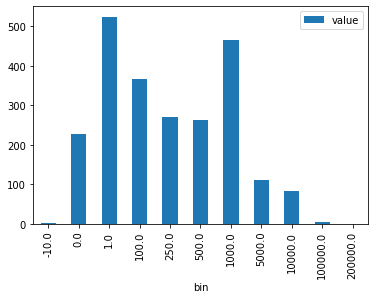

In [121]:
#examine the revenue ranges and create histogram

import numpy as np
rev = df_Att['Revenue_M']

CurrentRev = np.histogram(rev, bins=[-10,0,1,100,250,500,1000,5000,10000,100000,200000])
df_CurRev = pd.DataFrame(CurrentRev, index=['count','bin'])
df_CurRev.columns = df_CurRev.loc['bin']
df_CurRev.drop('bin',inplace = True)

df_CurRev = pd.melt(df_CurRev)
df_CurRev.plot.bar(x = 'bin')
print(df_CurRev)

In [122]:
#assign revenue segments to the attribute table based on the histogram above

def assign_bin(x):
    if x < 0:
        return '01: <0'
    elif x < 1:
        return '02: 0 to 1M'
    elif x<100:
        return  '03: 1M to 100M'
    elif x<250:
        return  '04: 100M to 250M'
    elif x<500:
        return  '05: 250M to 500M'
    elif x<1000:
        return  '06: 500M to 1B'
    elif x<5000:
        return  '07: 1B to 5B'
    elif x<10000:
        return  '08: 5B to 10B'
    elif x<100000:
        return '09: 10B to 100B'
    else:
        return '10: >100B'
    
    

df_Att['Bin'] = df_Att['Revenue_M'].apply(assign_bin)
df_Att.sort_values('Bin')

DaybyRev = df_Att.pivot_table(index = 'Bin', columns = 'DayofWeek', values = 'Symbol', aggfunc = 'count')
df_Att

,Symbol,Safe,Profitable,yearDifferenceGrouped,FoundingDateGrouped,usablePresidentGender,usableCEOGender,FiscalMonth,USACompany,MarketYearTrend,...,CEOTakeOver,PresidentAge,Revenue,presidentInChargeDuringIPO,PresidentTakeOver,Country,Revenue_M,Income_M,DayofWeek,Bin
0,A,0,1,Unknown,1951 - 2000,Blank,Blank,Oct,Yes,2.039844,...,2015.0,56.0,$4.47B,No,2015.0,US,4470.00,684.00,Thur,07: 1B to 5B
1,AAC,1,1,Unknown,2011 - present,Blank,male,Dec,Yes,0.881839,...,2013.0,NaN,$317.64M,No,2018.0,US,317.64,-20.58,Thur,05: 250M to 500M
2,AAOI,0,1,Unknown,1951 - 2000,Blank,Blank,Dec,Yes,1.443672,...,2014.0,54.0,$382.33M,No,2014.0,US,382.33,73.95,Thur,05: 250M to 500M
3,AAP,0,1,Unknown,1901 - 1950,Blank,Blank,Dec,Yes,-0.745906,...,2016.0,59.0,$9.37B,No,2016.0,US,9370.00,475.51,Thur,08: 5B to 10B
4,AAT,0,0,Unknown,2001 - 2010,Blank,Blank,Dec,Yes,2.263666,...,2015.0,79.0,$311.68M,No,2015.0,US,311.68,29.08,Thur,05: 250M to 500M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3754,ZSAN,0,0,Unknown,2011 - present,Blank,Blank,Dec,Yes,1.055378,...,2017.0,68.0,NaN,No,2017.0,US,0.00,-29.11,Tue,02: 0 to 1M
3756,ZTS,0,1,Unknown,2011 - present,Blank,male,Dec,Yes,2.456595,...,2012.0,46.0,$5.31B,No,2016.0,US,5310.00,864.00,Fri,08: 5B to 10B
3757,ZUMZ,1,1,Unknown,1951 - 2000,Blank,Blank,Jan,Yes,0.546793,...,2011.0,54.0,$927.40M,No,2017.0,US,927.40,26.80,Fri,06: 500M to 1B
3758,ZUO,0,0,Unknown,2001 - 2010,Unknown,mostly_male,Jan,Yes,0.794603,...,2017.0,NaN,$167.93M,NaN,NaN,US,167.93,-47.16,Thur,04: 100M to 250M


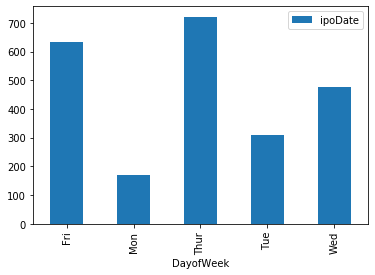

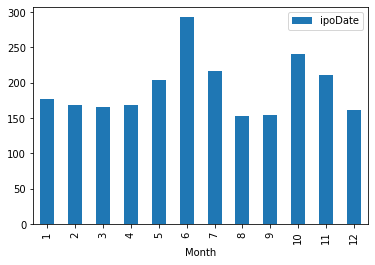

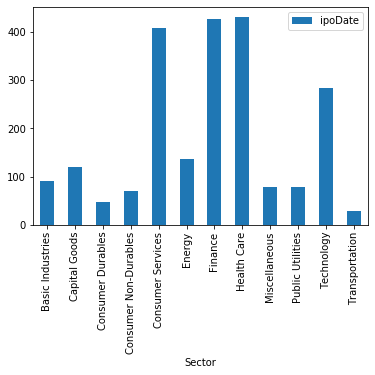

<Figure size 432x288 with 0 Axes>

In [123]:
#EXAMINE STATS
import matplotlib.pyplot as plt

DOW_freq = df_Att.pivot_table(index = 'DayofWeek', values = 'ipoDate', aggfunc = "count")
DOW_freq.plot(kind = 'bar')
plt.show()

Month_freq = df_Att.pivot_table(index = 'Month', values = 'ipoDate', aggfunc = "count")
Month_freq.plot(kind = 'bar')
plt.show()

Sector_freq = df_Att.pivot_table(index = 'Sector', values = 'ipoDate', aggfunc = "count")
Sector_freq.plot(kind = 'bar')
plt.show()


plt.clf()





In [124]:
#Thursday is the most popular IPO day across most revenue segments
DaybyRev.idxmax(axis = 1)

Bin
01: <0              Thur
02: 0 to 1M         Thur
03: 1M to 100M       Fri
04: 100M to 250M    Thur
05: 250M to 500M     Fri
06: 500M to 1B       Fri
07: 1B to 5B        Thur
08: 5B to 10B       Thur
09: 10B to 100B     Thur
10: >100B           Thur
dtype: object

In [125]:
dfMonth = df_Att.pivot_table(index = 'Bin', columns = 'Month', values = 'Symbol', aggfunc = 'count').fillna(0)


dfMonth


Month,1,2,3,4,5,6,7,8,9,10,11,12
Bin,,,,,,,,,,,,
01: <0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02: 0 to 1M,23.0,18.0,22.0,16.0,22.0,22.0,20.0,17.0,13.0,23.0,17.0,15.0
03: 1M to 100M,44.0,37.0,42.0,39.0,46.0,51.0,47.0,36.0,39.0,63.0,45.0,35.0
04: 100M to 250M,20.0,30.0,22.0,24.0,17.0,106.0,33.0,18.0,20.0,32.0,28.0,16.0
05: 250M to 500M,22.0,23.0,21.0,27.0,35.0,21.0,20.0,12.0,20.0,25.0,24.0,19.0
06: 500M to 1B,21.0,14.0,15.0,25.0,25.0,19.0,30.0,25.0,11.0,30.0,30.0,17.0
07: 1B to 5B,31.0,33.0,35.0,26.0,40.0,46.0,48.0,35.0,39.0,46.0,50.0,35.0
08: 5B to 10B,14.0,9.0,4.0,5.0,7.0,19.0,7.0,5.0,9.0,11.0,9.0,11.0
09: 10B to 100B,2.0,3.0,4.0,6.0,10.0,9.0,11.0,4.0,3.0,11.0,7.0,13.0


In [126]:
dfMonth.idxmax(axis = 1)

Bin
01: <0               5
02: 0 to 1M          1
03: 1M to 100M      10
04: 100M to 250M     6
05: 250M to 500M     5
06: 500M to 1B       7
07: 1B to 5B        11
08: 5B to 10B        6
09: 10B to 100B     12
10: >100B            2
dtype: int64

In [127]:
dfSector = df_Att.pivot_table(index = 'Bin', columns = 'Sector', aggfunc = 'count', values = 'Symbol')
dfSector.idxmin(axis = 1)

Bin
01: <0                  Consumer Services
02: 0 to 1M         Consumer Non-Durables
03: 1M to 100M             Transportation
04: 100M to 250M    Consumer Non-Durables
05: 250M to 500M        Consumer Durables
06: 500M to 1B             Transportation
07: 1B to 5B               Transportation
08: 5B to 10B              Transportation
09: 10B to 100B          Basic Industries
10: >100B                   Capital Goods
dtype: object

In [128]:
#Consumer services dominate IPO's in teh $250M to $100B Revenue range
dfSector = df_Att.pivot_table(index = 'Bin', columns = 'Sector', aggfunc = 'count', values = 'Symbol')
dfSector.idxmax(axis = 1)

Bin
01: <0              Consumer Services
02: 0 to 1M               Health Care
03: 1M to 100M            Health Care
04: 100M to 250M              Finance
05: 250M to 500M    Consumer Services
06: 500M to 1B      Consumer Services
07: 1B to 5B        Consumer Services
08: 5B to 10B       Consumer Services
09: 10B to 100B     Consumer Services
10: >100B                  Technology
dtype: object

In [129]:
dfState = df_Att.pivot_table(index = 'Sector', aggfunc = 'count', values = 'Symbol')
dfState.idxmax(axis = 0)

Symbol    Health Care
dtype: object

Industry
Major Pharmaceuticals                                            244
Major Banks                                                      156
Real Estate Investment Trusts                                    129
Business Services                                                108
Computer Software: Prepackaged Software                           79
Oil & Gas Production                                              65
EDP Services                                                      63
Industrial Machinery/Components                                   52
Savings Institutions                                              51
Biotechnology: Biological Products (No Diagnostic Substances)     49
Name: Symbol, dtype: int64


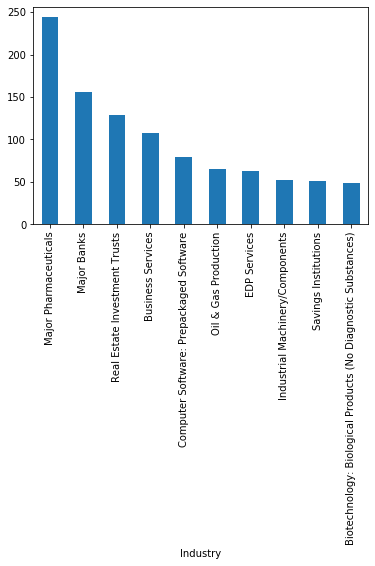

In [130]:
#Top 10 industries by IPO
TotalIPOs = df_Att.groupby('Industry')['Symbol'].count().sort_values(ascending = False).head(10)
TotalIPOs.plot(kind = 'bar')
print(TotalIPOs)

Industry
Integrated oil Companies                            36020.687500
Auto Manufacturing                                  32586.170000
Catalog/Specialty Distribution                      25426.373750
Life Insurance                                      19655.516250
Air Freight/Delivery Services                       15201.666667
Trucking Freight/Courier Services                   14586.434000
Computer Software: Programming, Data Processing     14526.085263
Medical Specialities                                13888.604000
Electronics Distribution                             9220.000000
Retail: Computer Software & Peripheral Equipment     9185.000000
Name: Revenue_M, dtype: float64


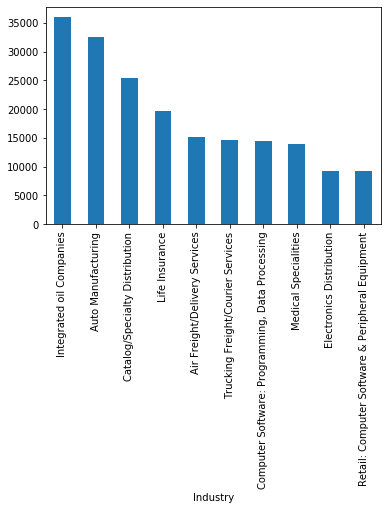

In [131]:
#Top 10 industries by avearge annual revenue
AverageRev = df_Att.groupby('Industry')['Revenue_M'].mean().sort_values(ascending = False).head(10)
AverageRev.plot(kind = 'bar')
print(AverageRev)

DayofWeek
Thur    2716.232368
Mon     2353.059083
Wed     2130.073969
Tue     1790.719149
Fri     1515.268951
Name: Revenue_M, dtype: float64


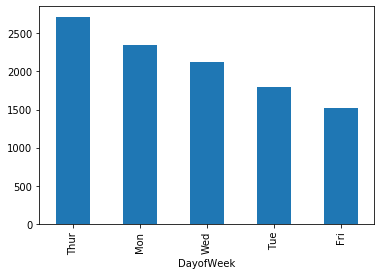

In [132]:
AverageRev = df_Att.groupby('DayofWeek')['Revenue_M'].mean().sort_values(ascending = False).head(10)
AverageRev.plot(kind = 'bar')
print(AverageRev)

                       Revenue_MAvg  Revenue_MCnt
Sector                                           
Transportation          6737.556207            29
Public Utilities        5216.714218            78
Consumer Non-Durables   4625.184159            69
Energy                  3747.683942           137
Consumer Durables       3456.828745            47
Capital Goods           3100.553672           119
Miscellaneous           2285.302025            79
Consumer Services       2240.299000           410
Basic Industries        2160.261667            90
Technology              2007.158215           284


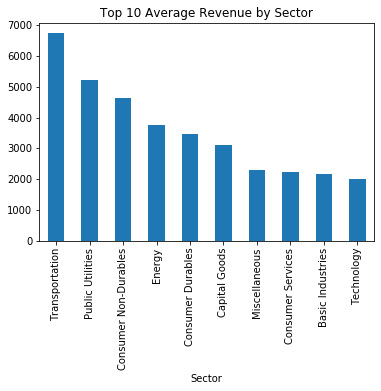

In [133]:
def stats(group, Col, Focus):
    
    Avg = df_Att.groupby(group)[Col].mean()
    Cnt =  df_Att.groupby(group)[Col].count()
    
    
    table =pd.merge(Avg,Cnt, on = group, how = 'inner', suffixes = ['Avg','Cnt'])
   
    Avg_Lab = Col+ 'Avg'
    Count_Lab = Col + 'Cnt'
    
    if Focus == 'Avg':
         table = table.sort_values(by = Avg_Lab, ascending = False ).head(10)
    else:
        table = table.sort_values(by = Count_Lab, ascending = False).head(10)
        
    print(table)
    
    if Focus == 'Avg':
        Avg.sort_values(ascending = False).head(10).plot(kind = 'bar', title = "Top 10 Average Revenue by " + group)
    else:
        Cnt.sort_values(ascending = False).head(10).plot(kind = 'bar', title = "Top 10 Total IPO's by " + group )
        
        
    
graph = stats('Sector', 'Revenue_M', 'Avg')

      Revenue_MAvg  Revenue_MCnt
Year                            
2001   8131.466383            47
1997   4870.870769            91
2012   2895.196838            99
2004   2766.952048            84
2003   2573.613810            42
1998   2556.423739            88
2002   2454.279659            41
2010   2420.427059           102
1999   2372.899348            92
2005   2211.258467            92


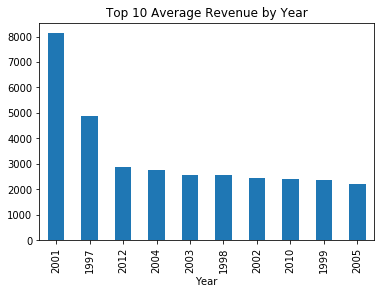

In [134]:
graph = stats('Year', 'Revenue_M', 'Avg')

In [135]:
dfAttPrice = pd.merge(df_Att, PriceComp(0,30,31,60), on = 'Symbol', how = 'left')
col = dfAttPrice.columns[-2]
dfAttPrice.groupby('Sector')[col].mean()

Sector
Basic Industries          7.664243
Capital Goods            11.654033
Consumer Durables         0.532599
Consumer Non-Durables     5.326274
Consumer Services         2.194846
Energy                   15.663399
Finance                   2.536369
Health Care               8.718856
Miscellaneous             8.094693
Public Utilities          1.111774
Technology               12.611288
Transportation            9.268887
Name: 0 to 30, dtype: float64

                         0 to 30   0 to 260
Sector                                     
Basic Industries        7.314679  28.615943
Capital Goods          11.422626  22.736707
Consumer Durables      -0.215098  47.052166
Consumer Non-Durables   5.746821  15.890456
Consumer Services       2.391992  10.123013
Energy                 16.296659  97.767265
Finance                 2.363786  20.264542
Health Care             8.814491  20.678001
Miscellaneous          12.517044  40.285871
Public Utilities        1.253347   5.160024
Technology             10.561591  22.351852
Transportation          9.945093  36.384479
                          0 to 30    0 to 260
Sector                                       
Basic Industries        28.516769   91.509851
Capital Goods           37.134662   79.473971
Consumer Durables       20.716550  278.045437
Consumer Non-Durables   32.155371   69.049612
Consumer Services       19.218253   53.303974
Energy                 143.100525  724.189844
Finance         

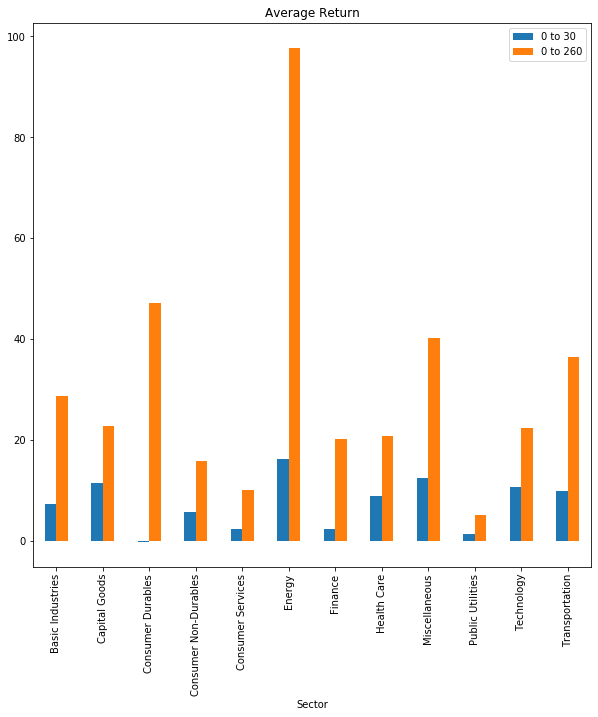

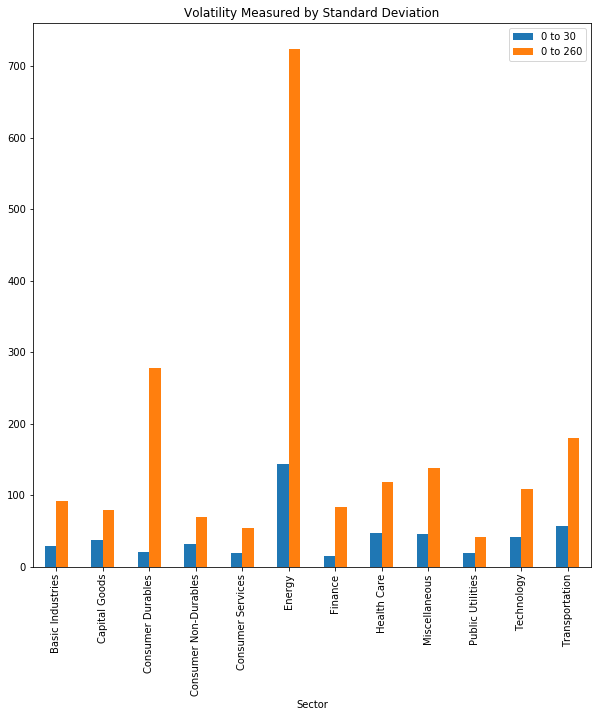

In [136]:
dfAttPrice = pd.merge(df_Att, PriceComp(0,30,0,260), on = 'Symbol', how = 'left')

def stats(group, r):
    
    col1 = dfAttPrice.columns[-2]
    col2 = dfAttPrice.columns[-1]
    
    Range1 = dfAttPrice.groupby(group)[col1].mean()
    Range2 =  dfAttPrice.groupby(group)[col2].mean()
    Range1_max = dfAttPrice.groupby(group)[col1].mean()
    Range2_max = dfAttPrice.groupby(group)[col2].max()
    Range1_min = dfAttPrice.groupby(group)[col1].min()
    Range2_min = dfAttPrice.groupby(group)[col2].min()
    Range1_std = dfAttPrice.groupby(group)[col1].std()
    Range2_std = dfAttPrice.groupby(group)[col2].std()
    
    Avg = pd.merge(Range1,Range2, on = group, how = 'left', suffixes = ['1','2'])
    Max = pd.merge(Range1_max,Range2_max, on = group, how = 'left', suffixes = ['1','2'])
    Min = pd.merge(Range1_min,Range2_min, on = group, how = 'left', suffixes = ['1','2'])
    std = pd.merge(Range1_std,Range2_std, on = group, how = 'left', suffixes = ['1','2'])
    All = pd.concat([Avg,Max,Min, std], axis = 1)
    All.columns = ['Range1Avg', 'Range2Avg', 'Range1Max', 'Range2Max', 'Range1Min', 'Range2Min', 'Range1Std','Range2Std']
   
    
    if r == 'Avg':
        return Avg
    elif r == 'Max':
        return Max
    elif r == 'Min': 
        return Min
    elif r == 'Std': 
        return std
    elif r == 'All': 
        return All

df_avg = stats('Sector','Avg')
df_std = stats('Sector', 'Std')

df_avg.plot(kind = 'bar', figsize = (10,10), title = 'Average Return')
print(df_avg)
df_std.plot(kind = 'bar', figsize = (10,10), title = 'Volatility Measured by Standard Deviation')
print(df_std)


In [137]:
dfAttPrice = pd.merge(df_Att, PriceComp(0,30,31,60), on = 'Symbol', how = 'left')
dfAttPrice.shape

(2312, 57)

In [138]:
stats('Sector','All')

,Range1Avg,Range2Avg,Range1Max,Range2Max,Range1Min,Range2Min,Range1Std,Range2Std
Sector,,,,,,,,
Basic Industries,7.664243,2.804514,7.664243,180.875618,-53.333333,-83.333333,28.312180,27.625151
Capital Goods,11.654033,3.643942,11.654033,191.120815,-38.081075,-58.166476,36.569559,28.809080
Consumer Durables,0.532599,70.405844,0.532599,2966.666667,-50.555556,-27.376216,20.538376,447.171308
Consumer Non-Durables,5.326274,2.023652,5.326274,114.912281,-51.428571,-60.000000,31.897331,20.238998
Consumer Services,2.194846,1.243027,2.194846,120.000000,-61.904762,-47.248034,19.480383,15.065369
Energy,15.663399,4.162708,15.663399,243.992248,-37.542662,-35.132743,139.223551,25.110137
Finance,2.536369,1.471996,2.536369,76.200152,-43.809524,-61.376404,13.475613,11.212568
Health Care,8.718856,4.757050,8.718856,372.222222,-68.292683,-72.696970,46.035621,38.616899
Miscellaneous,8.094693,6.901275,8.094693,183.707827,-45.625000,-52.234475,30.491850,27.475769


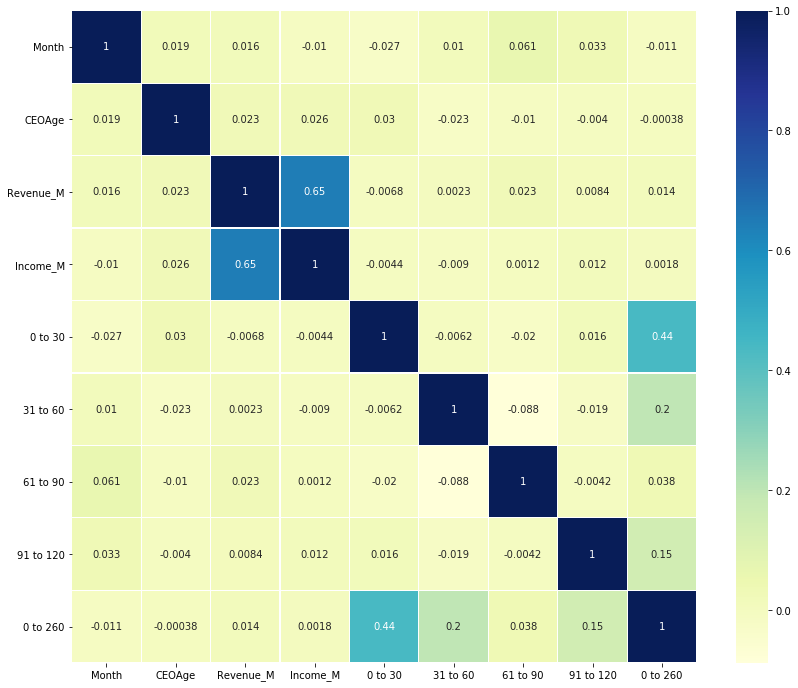

In [139]:
import seaborn as sns
df_corr = df_Att.loc[:,['Symbol','Month', 'CEOAge','Revenue_M', 'Income_M']]
df_corr = pd.merge(df_corr, PriceComp(0,30,31,60), on = 'Symbol', how = 'left')
df_corr = pd.merge(df_corr, PriceComp(61,90,91,120), on = 'Symbol', how = 'left')
df_corr = pd.merge(df_corr, PriceComp(0,260,0,0), on = 'Symbol', how = 'left')
df_corr.drop(df_corr.columns[-1], axis = 1, inplace = True)
#df_corr = df_corr.rename(columns = {'Range1_x':'Q1','Range2_x':'Q2','Range1_y':'Q3','Range2_y':'Q4','Range1':'FY'})

plt.figure(figsize=(14,12))
sns.heatmap(df_corr.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
plt.yticks(rotation=0);




In [140]:
df_Annual = pd.merge(df_Att, PriceComp(0,260,0,0), on = 'Symbol', how = 'left')
df_Annual.drop(df_Annual.columns[-1], axis = 1,inplace = True)

df_Annual = df_Annual.loc[:,['Year','Sector','0 to 260']]
df_Annual = df_Annual.pivot_table(index = 'Sector', columns = 'Year', values = '0 to 260', aggfunc = 'mean')

df_Annual


Year,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Sector,,,,,,,,,,,,,,,,,,,,,
Basic Industries,58.554848,24.782403,-45.001387,101.549145,55.975936,NaN,-7.218935,203.233902,44.920332,-3.900217,...,-2.636087,31.392675,20.445184,30.963084,-2.241628,97.602953,-13.010419,-4.345241,28.358898,56.814701
Capital Goods,32.949763,8.680939,61.743355,64.025476,16.896946,25.794227,NaN,NaN,12.602116,49.431297,...,-77.125984,32.102540,-0.822505,-2.017750,62.531252,79.738230,-2.091893,-25.102728,55.208285,10.544501
Consumer Durables,37.270304,11.936148,-47.460733,-61.992994,18.233333,12.904132,-39.827798,29.161290,3.625731,-17.624601,...,-34.376130,8.229426,108.550753,883.333333,8.321446,13.196248,14.941972,10.997205,79.555556,NaN
Consumer Non-Durables,-15.602675,-4.984251,-38.030769,-15.917797,0.870293,44.761331,2.028986,18.052738,41.031111,33.659945,...,-27.741492,26.768802,107.096690,50.977825,34.425513,0.224771,-55.791847,-5.432550,32.941320,-37.786561
Consumer Services,33.786002,25.045754,-2.739250,-26.698622,-57.066814,46.740994,25.739204,29.099645,24.460261,33.634866,...,39.062133,14.137173,7.044097,-7.877416,27.272070,8.700132,6.276102,1.216965,14.171485,-14.010941
Energy,64.325088,-30.909420,0.000000,6.278948,-55.075153,8.926055,38.278861,45.150776,44.751267,35.063140,...,NaN,-8.457078,968.978314,13.142049,252.032574,34.533687,-27.801203,-11.023992,15.090359,-17.219698
Finance,49.210491,33.788586,55.077883,6.765850,16.875401,18.082487,36.505522,24.188053,16.151709,26.561677,...,3.814325,30.440705,1.296191,11.632840,47.516520,31.401048,6.881157,4.718643,20.123064,10.142291
Health Care,18.212142,25.112420,58.145731,185.773091,-19.749202,-11.256410,103.000000,27.404838,35.693273,0.711367,...,87.528987,-51.960046,127.941634,-3.416846,54.617729,23.935976,30.212413,-28.954218,26.342476,168.137768
Miscellaneous,-3.575869,43.187816,386.547522,-56.148127,69.937500,87.285189,NaN,NaN,-8.158576,70.226410,...,-35.096713,-88.125000,29.845788,7.458409,58.044391,28.904894,51.699763,-1.097504,4.289172,NaN
